## Analysis of the frame count

In [6]:
# imports
import sys
import os

from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

from functions_EDX import *
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

from sklearn.metrics import DistanceMetric
import tifffile as tif

In [9]:
def compute_inner_outer_similarity_with_distances(dist_to_ref, labels):
    # Initialize lists to store inner-class similarities and outer-class dissimilarities
    inner_class_similarities = []
    outer_class_dissimilarities = []
    
    # Get unique labels
    unique_labels = np.unique(labels)
    
    # Compute inner-class similarity and outer-class dissimilarity for each cluster
    for label in unique_labels:
        # Get indices of data points belonging to the current cluster
        cluster_indices = np.where(labels == label)[0]
        
        # Get distances from the reference for data points in the current cluster
        cluster_distances = dist_to_ref[cluster_indices]
        
        # Compute average distance within the cluster
        intra_cluster_distances = np.mean(np.abs(np.subtract.outer(cluster_distances, cluster_distances)))
        inner_class_similarities.append(intra_cluster_distances)
        
        # Get distances from the reference for data points in other clusters
        other_cluster_indices = np.where(labels != label)[0]
        other_cluster_distances = dist_to_ref[other_cluster_indices]
        
        # Compute average distance to points in other clusters
        inter_cluster_distances = np.mean(np.abs(np.subtract.outer(cluster_distances, other_cluster_distances)))
        outer_class_dissimilarities.append(inter_cluster_distances)
    
    # Compute the ratio of inner-class similarity to outer-class dissimilarity
    similarity_dissimilarity_ratio = np.mean(inner_class_similarities) / np.mean(outer_class_dissimilarities)
    
    return similarity_dissimilarity_ratio

# Euclidean distance
def euc(array1, array2):
    return np.sqrt(np.sum((array1 - array2)**2))

In [7]:
mask_dir = "hand_annotated"
file_names = os.listdir(mask_dir)
file_names = [name for name in file_names if name.endswith('tif')]
file_names.sort()

mask_paths = [os.path.join(mask_dir,file_name) for file_name in file_names]


colors = ['w','r','g','b','c','m','y']
newcmap = ListedColormap(colors)
all_masks = np.zeros((size_xy,size_xy),dtype='int')
for i in range(6):
    x = tif.imread(mask_paths[i])
    x = rebin_XY(x).astype('bool')
    #print(np.unique(x*(i+1)))
    all_masks = all_masks + x*(i+1)


In [10]:
frames = [i for i in range(2,102,2)]
InnerOuterRatios = np.zeros(len(frames))

all_embeddings = []
all_y = []
for file_idx in range(len(frames)):
    print('%03d frames' % frames[file_idx])
    spectrum_folder = '/Volumes/Microscopy4/EDX_data/old_datasets/Spectrum2D_extendedGauss1_3_5/'
    file_names = []
    tmp = os.listdir(spectrum_folder)
    for filename in tmp:
        if filename.endswith('.npz'):
            file_names.append(filename)
    
    file_names = sorted(file_names)
    files = [os.path.join(spectrum_folder,file_name) for file_name in file_names]
    spectrum_2D = np.load(files[file_idx])['spectrum_2D']
    size_xy = 1024

    
    # The distances to the mean
    all_idx = all_masks.reshape((size_xy**2))
    mean_spectrum_nonAnnotated =  spectrum_2D[all_idx==0,:].mean(axis=0)
    num_annotated = np.sum(all_idx>0)

    distancesToMean = []
    for i in range(1,7):
        
        class_count = np.sum(all_idx==i)
        #print("Class %02d has %05d annotations" % (i,class_count)) 
        spectra_of_class = spectrum_2D[all_idx==i,:]
        distances_to_class = np.zeros((class_count))
        for j in range(class_count):
            distances_to_class[j] = euc(mean_spectrum_nonAnnotated,spectra_of_class[j,:])            
        distancesToMean.append(distances_to_class)

    
    # inner outer ratio 
    annotated_idx = np.sort(all_idx[all_idx>0])
    x = np.array([i for i in range(num_annotated)])
    y = MinMaxScaler().fit_transform(np.hstack(distancesToMean).reshape(-1, 1))
    all_y.append(y)
    
    similarity_dissimilarity_ratio = compute_inner_outer_similarity_with_distances(y,np.sort(all_idx[all_idx>0]))
    print("Ratio:", similarity_dissimilarity_ratio)
    InnerOuterRatios[file_idx] = similarity_dissimilarity_ratio
    

002 frames
Ratio: 0.9198074178422441
004 frames
Ratio: 0.7382374110182574
006 frames
Ratio: 0.4849205099855914
008 frames
Ratio: 0.3698901794783777
010 frames
Ratio: 0.3341474886079501
012 frames
Ratio: 0.3215287431891883
014 frames
Ratio: 0.3175046062272105
016 frames
Ratio: 0.3178146717712726
018 frames
Ratio: 0.3183984451507717
020 frames
Ratio: 0.3178039742689866
022 frames
Ratio: 0.31719556627092604
024 frames
Ratio: 0.3160837248408533
026 frames
Ratio: 0.3159982641992873
028 frames
Ratio: 0.315007772780976
030 frames
Ratio: 0.3137846160309209
032 frames
Ratio: 0.3128849580758478
034 frames
Ratio: 0.31177662951358037
036 frames
Ratio: 0.3109469068120259
038 frames
Ratio: 0.3105914485888063
040 frames
Ratio: 0.3104509064323428
042 frames
Ratio: 0.311813039752843
044 frames
Ratio: 0.3105293533971855
046 frames
Ratio: 0.30575522699639535
048 frames
Ratio: 0.2989114621834995
050 frames
Ratio: 0.29357652120037075
052 frames
Ratio: 0.29204887536132473
054 frames
Ratio: 0.292130400443452

In [43]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

# this one makes the ticks into text in the exported svgs
plt.rcParams['svg.fonttype'] = 'none'

plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20

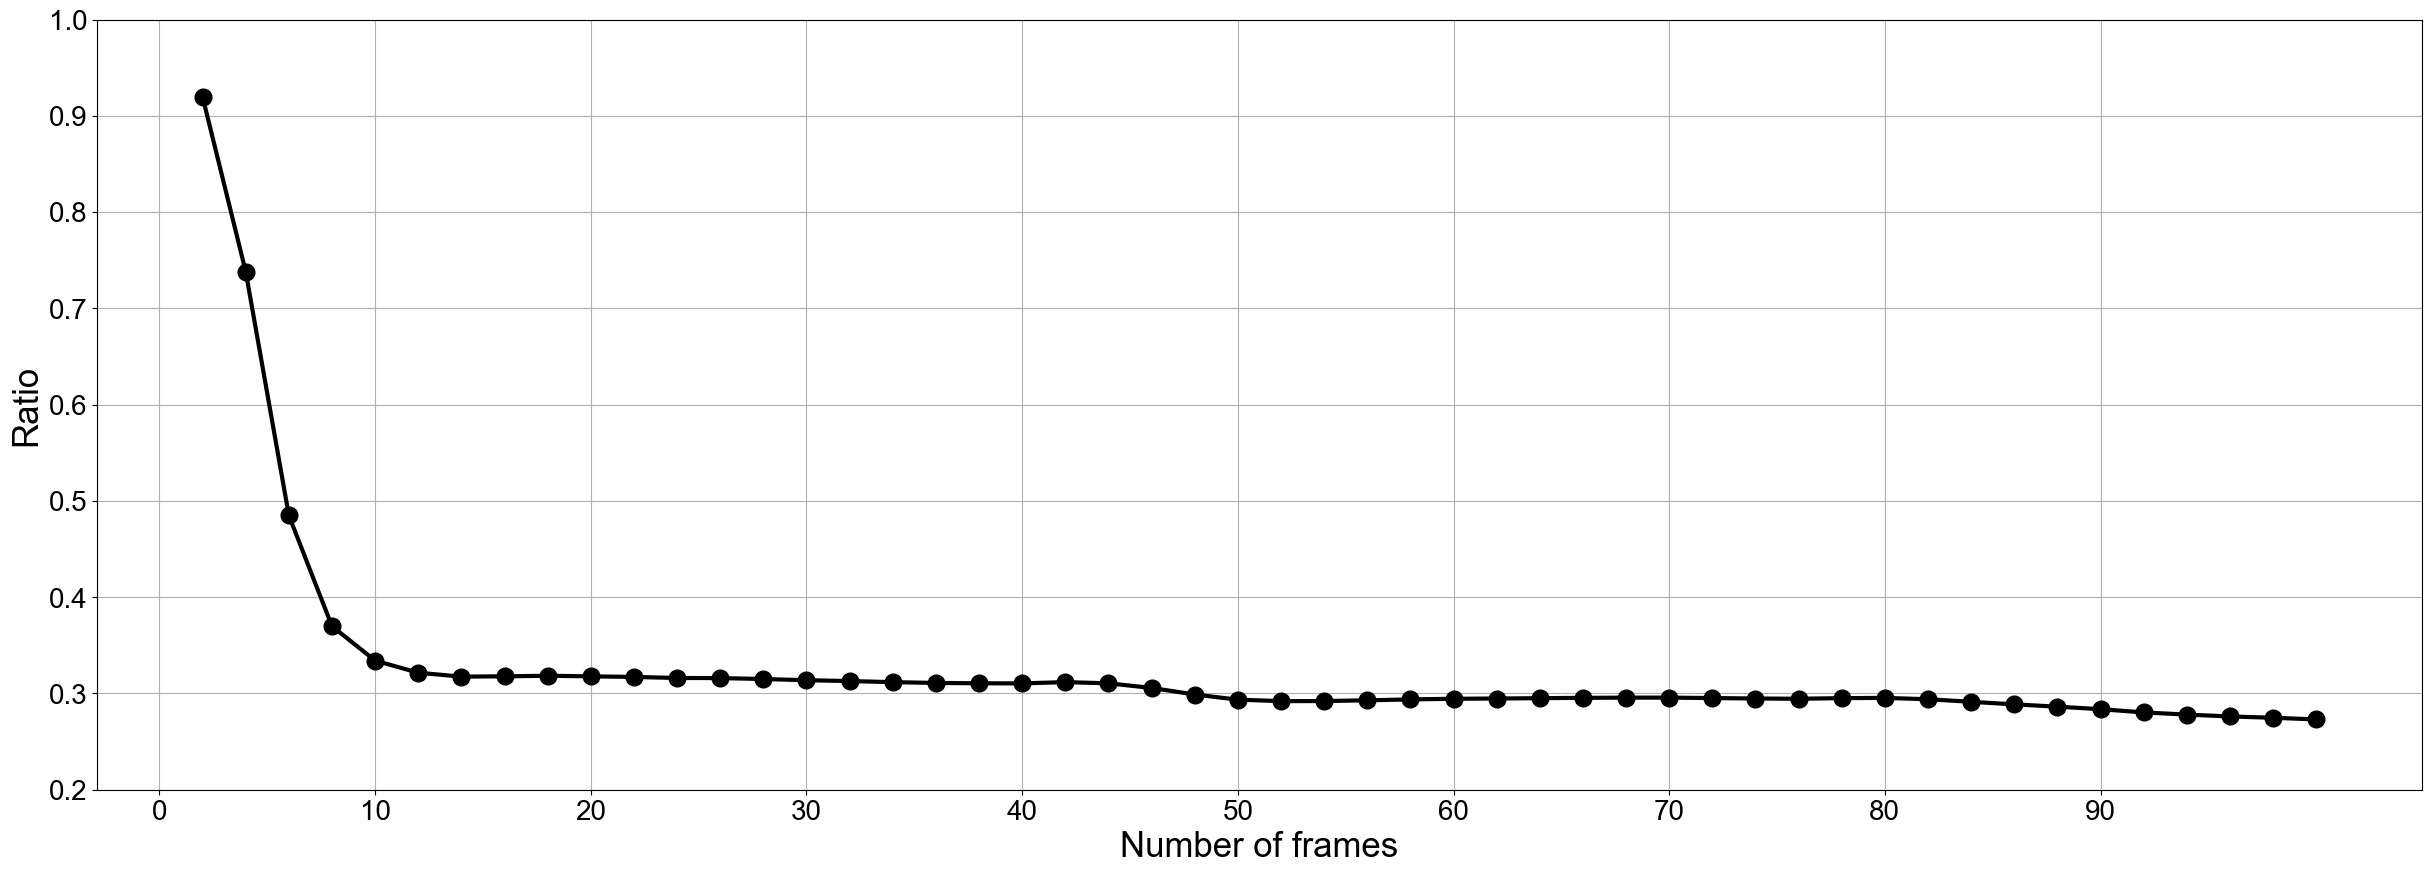

In [44]:
f,ax = plt.subplots(figsize=(30,10))
#plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
plt.rcParams.update({'font.size': 25})

ax.plot(range(2,102,2),InnerOuterRatios,'ko-',markersize=12,linewidth=3)
#ax.plot(range(4,100,2),np.diff(InnerOuterRatios),'kx-',markersize=12)
ax.set_xticks(range(0,100,10))

ax.grid(True)
ax.set_ylim(0.2,1)
ax.set_ylabel('Ratio')
ax.set_xlabel('Number of frames')
plt.savefig("Exports/frame_count.png",dpi=300) #,bbox_inches='tight')
plt.savefig("Exports/frame_count.svg")
plt.show()


In [14]:
np.savez_compressed('InnerOuterRatios',InnerOuterRatios=InnerOuterRatios)